In [26]:
# lib import
import os, time, copy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.spatial import distance
from scipy.sparse import csr_matrix as sparse_matrix
from scipy.special import ellipj, ellipk
from scipy.spatial.distance import pdist
from KernelEDMD import OnlineKernelEDMD as kEDMD

# vdP experiment

In [27]:
# generate mesh VdP data
def van_der_pol(t, x, mu):
    dx0dt = x[1]
    dx1dt = mu*(1 - x[0]**2)*x[1] - x[0]
    return [dx0dt, dx1dt]
mesh_num = 5
dt = 1e-2
delta_t = 0.05
step = 3e2
interval = int(delta_t/dt)
print("interval:",interval)
print("num of solution:", int(step+interval))
print("num of snapshots:", int((step+interval)/interval))
mu = 1.0
mu_1 = 1.0
T = dt * (step+interval)
T = round(T, 2)
print("time span=","0 to",T)
time_step = (0, T)
time_step_test = (0, T+5.0)

# First Quadrant (1 ~ 2)
x1 = np.linspace(1, 2, mesh_num)
y1 = np.linspace(1, 2, mesh_num)
X1, Y1 = np.meshgrid(x1, y1)
InitDataPoint = np.c_[np.ravel(X1), np.ravel(Y1)]

# Third Quadrant (-2 ~ -1)
x2 = np.linspace(-2, -1, mesh_num)
y2 = np.linspace(-2, -1, mesh_num)
X2, Y2 = np.meshgrid(x2, y2)
InitNewDataPoint = np.c_[np.ravel(X2), np.ravel(Y2)]

rng = np.random.default_rng(seed=0)
InitTestDataPoint_1 = 1*rng.random((1,2))+1
sol_test = solve_ivp(van_der_pol, t_span=time_step_test, y0=InitTestDataPoint_1.flatten(), args=[mu], rtol=1e-8, t_eval=np.arange(0, T+5.0, dt))
TestDataPoint_1 = sol_test.y

rng = np.random.default_rng(seed=0)
InitTestDataPoint_3 = 1*rng.random((1,2))-2
sol_test = solve_ivp(van_der_pol, t_span=time_step_test, y0=InitTestDataPoint_3.flatten(), args=[mu_1], rtol=1e-8, t_eval=np.arange(0, T+5.0, dt))
TestDataPoint_3 = sol_test.y
TrainDataPoints = InitDataPoint[0].reshape(-1,1)
OnlineDataPoints = InitNewDataPoint[0].reshape(-1,1)
for x in InitDataPoint:
    sol_train = solve_ivp(van_der_pol, t_span=time_step, y0=x, args=[mu], rtol=1e-8, t_eval=np.arange(0, T, dt))
    TrainDataPoints = np.hstack([TrainDataPoints, sol_train.y])
    
for x in InitNewDataPoint:
    sol_online = solve_ivp(van_der_pol, t_span=time_step, y0=x, args=[mu_1], rtol=1e-8, t_eval=np.arange(0, T, dt))
    OnlineDataPoints = np.hstack([OnlineDataPoints, sol_online.y])
TrainDataPoints = TrainDataPoints[:, 1::interval]
OnlineDataPoints = OnlineDataPoints[:, 1::interval]
print("whole data size:", TrainDataPoints.shape)

interval: 5
num of solution: 305
num of snapshots: 61
time span= 0 to 3.05
whole data size: (2, 1525)


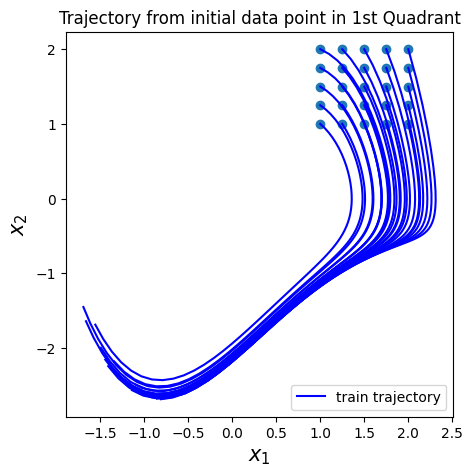

In [28]:
LABEL=True
n = int((step+interval)/interval)-1
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X1, Y1)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(TrainDataPoints[0, i*n+i:(i+1)*n+i], TrainDataPoints[1, i*n+i:(i+1)*n+i], color="blue", label="train trajectory")
        LABEL=False
    else:
        ax.plot(TrainDataPoints[0, i*n+i:(i+1)*n+i], TrainDataPoints[1, i*n+i:(i+1)*n+i], color="blue")
ax.legend(loc="lower right")
ax.set_title("Trajectory from initial data point in 1st Quadrant")
ax.set_xlabel(r"$x_1$", size=15)
ax.set_ylabel(r"$x_2$", size=15)
plt.show()

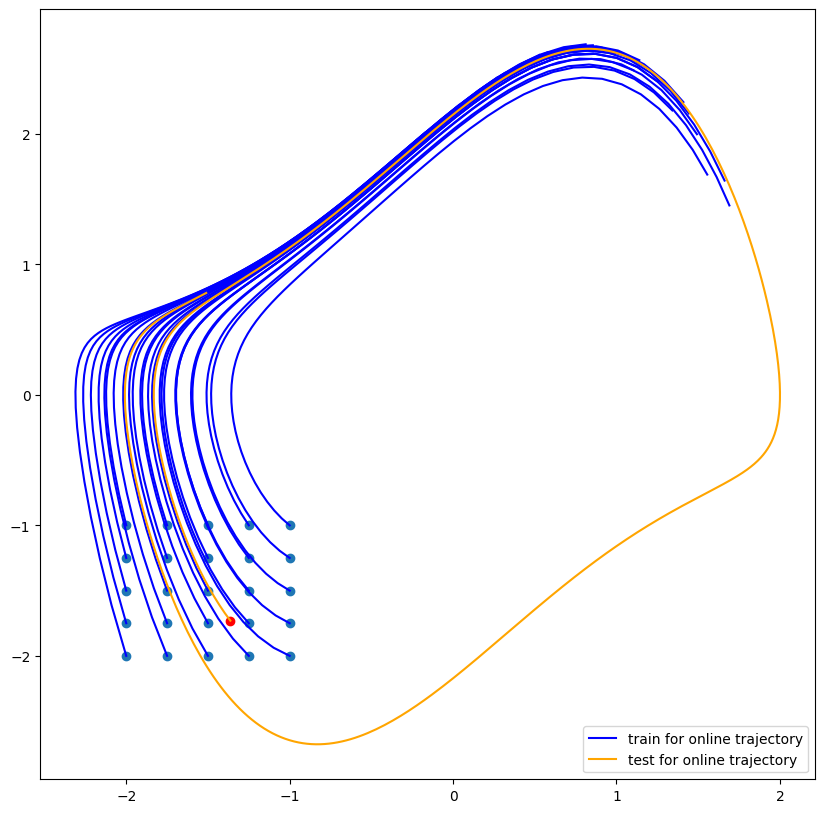

In [29]:
LABEL=True
n = int((step+interval)/interval)-1
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X2, Y2)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue", label="train for online trajectory", )
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue")
ax.scatter(InitTestDataPoint_3[:,0], InitTestDataPoint_3[:,1], color="red")
ax.plot(TestDataPoint_3[0, :], TestDataPoint_3[1,:], color="orange", label="test for online trajectory")
ax.legend(loc="lower right")
plt.show()

In [30]:
threshold=1e-5
n = int((step+interval)/interval)-1
mask_x = [True for _ in range(TrainDataPoints.shape[1])]
mask_y = [True for _ in range(TrainDataPoints.shape[1])]
mask_y[0] = False
for i in range(mesh_num**2):
    mask_x[(i+1) * n + i] = False
    if not (i+1) * n + i + 1 > len(mask_y)-1:
        mask_y[(i+1) * n + i + 1] = False
X_mesh = TrainDataPoints[:, mask_x]
Y_mesh = TrainDataPoints[:, mask_y]
print(X_mesh.shape)
kedmd_mesh = kEDMD(X=X_mesh, Y=Y_mesh, kernel="polynomial", p=3, c=1)
kedmd_mesh.fit(thr=threshold)
print("fit done")
preds = [InitTestDataPoint_1.flatten()]
pred = kedmd_mesh.predict(InitTestDataPoint_1.reshape(-1, 1))
preds.append(pred)
for i in range(int(TestDataPoint_1.shape[1]/interval)+200):
    pred = kedmd_mesh.predict(pred)
    preds.append(pred)
preds = np.array(preds)

(2, 1500)
fit done


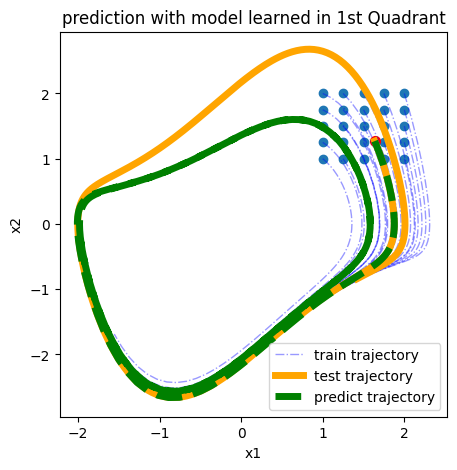

In [31]:
lstyle = "-."
alpha=0.4
lwidth = 1
LABEL=True
n = int((step+interval)/interval)-1
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X1, Y1)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(TrainDataPoints[0, i*n+i:(i+1)*n+i], TrainDataPoints[1, i*n+i:(i+1)*n+i], color="blue", label="train trajectory", alpha=alpha, linestyle=lstyle, linewidth=lwidth)
        LABEL=False
    else:
        ax.plot(TrainDataPoints[0, i*n+i:(i+1)*n+i], TrainDataPoints[1, i*n+i:(i+1)*n+i], color="blue", alpha=alpha, linestyle=lstyle, linewidth=lwidth)
ax.scatter(InitTestDataPoint_1[:,0], InitTestDataPoint_1[:,1], color="red", s=50)
ax.plot(TestDataPoint_1[0, :], TestDataPoint_1[1,:], color="orange", label="test trajectory", linewidth=5, linestyle="-")
ax.plot(preds[:, 0], preds[:, 1], label="predict trajectory", color="green", linewidth=5, linestyle="--")
ax.legend(loc="lower right")
ax.set_title("prediction with model learned in 1st Quadrant")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

In [32]:
mask_x = [True for _ in range(OnlineDataPoints.shape[1])]
mask_y = [True for _ in range(OnlineDataPoints.shape[1])]
mask_y[0] = False
for i in range(mesh_num**2):
    mask_x[(i+1) * n + i] = False
    if not (i+1) * n + i + 1 > len(mask_y)-1:
        mask_y[(i+1) * n + i + 1] = False
X_mesh_online = OnlineDataPoints[:, mask_x]
Y_mesh_online = OnlineDataPoints[:, mask_y]

In [33]:
preds_3rd = [InitTestDataPoint_3.flatten()]
pred = kedmd_mesh.predict(InitTestDataPoint_3.reshape(-1, 1))
preds_3rd.append(pred)
for i in range(int(TestDataPoint_3.shape[1]/interval)+15):
    pred = kedmd_mesh.predict(pred)
    preds_3rd.append(pred)
preds_3rd = np.array(preds_3rd)

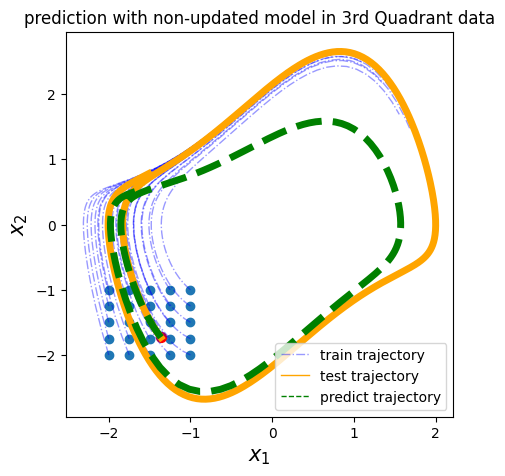

In [34]:
LABEL=True
n = int((step+interval)/interval)-1
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X2, Y2)
for i in range(mesh_num**2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue", label="train trajectory", alpha=alpha, linestyle=lstyle, linewidth=lwidth)
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue", alpha=alpha, linestyle=lstyle, linewidth=lwidth)
ax.scatter(InitTestDataPoint_3[:,0], InitTestDataPoint_3[:,1], color="red", s=50)
ax.plot(TestDataPoint_3[0, :], TestDataPoint_3[1,:], color="orange", label="test trajectory", linewidth=5, linestyle="-")
ax.plot(preds_3rd[:,0], preds_3rd[:,1], label="predict trajectory", color="green", linewidth=5, linestyle="--")
ax.set_title("prediction with non-updated model in 3rd Quadrant data")
leg = ax.legend(loc="lower right")
leg.get_lines()[1].set_linewidth(1)
leg.get_lines()[2].set_linewidth(1)
leg.get_lines()[0].set_linewidth(1)
ax.set_xlabel(r"$x_1$", size=15)
ax.set_ylabel(r"$x_2$", size=15)
plt.show()

In [35]:
mask_x = [True for _ in range(TrainDataPoints.shape[1])]
mask_y = [True for _ in range(TrainDataPoints.shape[1])]
mask_y[0] = False
threshold=1e-5
n = int((step+interval)/interval)-1
for i in range(mesh_num**2):
    mask_x[(i+1) * n + i] = False
    if not (i+1) * n + i + 1 > len(mask_y)-1:
        mask_y[(i+1) * n + i + 1] = False
X_mesh = TrainDataPoints[:, mask_x]
Y_mesh = TrainDataPoints[:, mask_y]
kedmd_mesh_window = kEDMD(X=X_mesh, Y=Y_mesh, kernel="polynomial", p=3, c=1)

kedmd_mesh.fit(thr=threshold)
kedmd_mesh_window.fit(thr=threshold)
new_x = OnlineDataPoints.T[0]
new_y = OnlineDataPoints.T[0]
_X = np.hstack([new_x.reshape(-1,1), X_mesh[:, 1:]])
_Y = np.hstack([new_y.reshape(-1,1), Y_mesh[:, 1:]])
n_singlarvalues = []
preds_window = []
times = []
for i in range(InitDataPoint.shape[0]):
    for j in range(n):
        swap_idx = i*n+j
        print(swap_idx)
        new_x = OnlineDataPoints.T[i*n+j+i]
        new_y = OnlineDataPoints.T[i*n+j+1+i]
        print("新しいデータ:\n", new_x, new_y)
        s = time.time()
        kedmd_mesh_window.window_update(new_x, new_y, idx=swap_idx, thr=threshold)
        e = time.time()
        times.append(e-s)
        print("window_update:{}".format(kedmd_mesh_window.s.shape))
        # 各更新ステップでの予測を得る
        preds_3rd_window = [InitTestDataPoint_3.flatten()]
        pred_window = kedmd_mesh_window.predict(InitTestDataPoint_3.reshape(-1, 1))
        for _ in range(500):
            pred_window = kedmd_mesh_window.predict(pred_window)
            preds_3rd_window.append(pred_window)
        preds_window.append(np.array(preds_3rd_window))
        print("===")

0
新しいデータ:
 [-2. -2.] [-2.09016525 -1.61066495]
window_update:(10,)
===
1
新しいデータ:
 [-2.09016525 -1.61066495] [-2.16159627 -1.25287423]
window_update:(10,)
===
2
新しいデータ:
 [-2.16159627 -1.25287423] [-2.21614721 -0.93653976]
window_update:(10,)
===
3
新しいデータ:
 [-2.21614721 -0.93653976] [-2.25600384 -0.66524576]
window_update:(10,)
===
4
新しいデータ:
 [-2.25600384 -0.66524576] [-2.28340675 -0.43794691]
window_update:(10,)
===
5
新しいデータ:
 [-2.28340675 -0.43794691] [-2.30046741 -0.2507518 ]
window_update:(10,)
===
6
新しいデータ:
 [-2.30046741 -0.2507518 ] [-2.30906299 -0.09841782]
window_update:(10,)
===
7
新しいデータ:
 [-2.30906299 -0.09841782] [-2.31079719  0.0246235 ]
window_update:(10,)
===
8
新しいデータ:
 [-2.31079719  0.0246235 ] [-2.30700066  0.12364621]
window_update:(10,)
===
9
新しいデータ:
 [-2.30700066  0.12364621] [-2.29875465  0.20332202]
window_update:(10,)
===
10
新しいデータ:
 [-2.29875465  0.20332202] [-2.28692439  0.26761459]
window_update:(10,)
===
11
新しいデータ:
 [-2.28692439  0.26761459] [-2.2721947   0.3197

/Users/sakuraiyamato/Desktop/lab/EchoStateNetwork/OKEDMD/KernelEDMD.py:65: RuntimeWarning: overflow encountered in power
  phi_Xx = (self.c + x.T @ self.X)**self.p @ self.eigenvectors
/Users/sakuraiyamato/Desktop/lab/EchoStateNetwork/OKEDMD/KernelEDMD.py:65: RuntimeWarning: invalid value encountered in matmul
  phi_Xx = (self.c + x.T @ self.X)**self.p @ self.eigenvectors


===
1441
新しいデータ:
 [-1.04868904 -0.94636165] [-1.09452354 -0.88596226]
window_update:(12,)
===
1442
新しいデータ:
 [-1.09452354 -0.88596226] [-1.13718713 -0.8196916 ]
window_update:(13,)
===
1443
新しいデータ:
 [-1.13718713 -0.8196916 ] [-1.17641157 -0.74856503]
window_update:(14,)
===
1444
新しいデータ:
 [-1.17641157 -0.74856503] [-1.21198109 -0.6736796 ]
window_update:(15,)
===
1445
新しいデータ:
 [-1.21198109 -0.6736796 ] [-1.24373557 -0.59614959]
window_update:(15,)
===
1446
新しいデータ:
 [-1.24373557 -0.59614959] [-1.27156988 -0.51705643]
window_update:(16,)
===
1447
新しいデータ:
 [-1.27156988 -0.51705643] [-1.29543175 -0.43741514]
window_update:(17,)
===
1448
新しいデータ:
 [-1.29543175 -0.43741514] [-1.31531773 -0.35813057]
window_update:(18,)
===
1449
新しいデータ:
 [-1.31531773 -0.35813057] [-1.33126406 -0.27997199]
window_update:(19,)
===
1450
新しいデータ:
 [-1.33126406 -0.27997199] [-1.34334378 -0.20356739]
window_update:(20,)
===
1451
新しいデータ:
 [-1.34334378 -0.20356739] [-1.35165786 -0.12939437]
window_update:(21,)
===
1452
新

In [36]:
_k = kEDMD(X=kedmd_mesh.X, Y=kedmd_mesh.Y, kernel="polynomial", p=2, c=1)
_k.fit(thr=1e-3)

In [37]:
print(InitTestDataPoint_3)
print(InitTestDataPoint_1)
preds_3rd = [InitTestDataPoint_3.flatten()]
preds_3rd_window = [InitTestDataPoint_3.flatten()]

pred = kedmd_mesh.predict(InitTestDataPoint_3.reshape(-1, 1))
pred_window = kedmd_mesh_window.predict(InitTestDataPoint_3.reshape(-1, 1))

preds_3rd.append(pred)
preds_3rd_window.append(pred_window)

for i in range(1000):
    pred = kedmd_mesh.predict(pred)
    pred_window = kedmd_mesh_window.predict(pred_window)
    preds_3rd.append(pred)
    preds_3rd_window.append(pred_window)
preds_3rd = np.array(preds_3rd)
preds_3rd_window = np.array(preds_3rd_window)

[[-1.36303831 -1.73021329]]
[[1.63696169 1.26978671]]


[[-1.36303831 -1.73021329]]


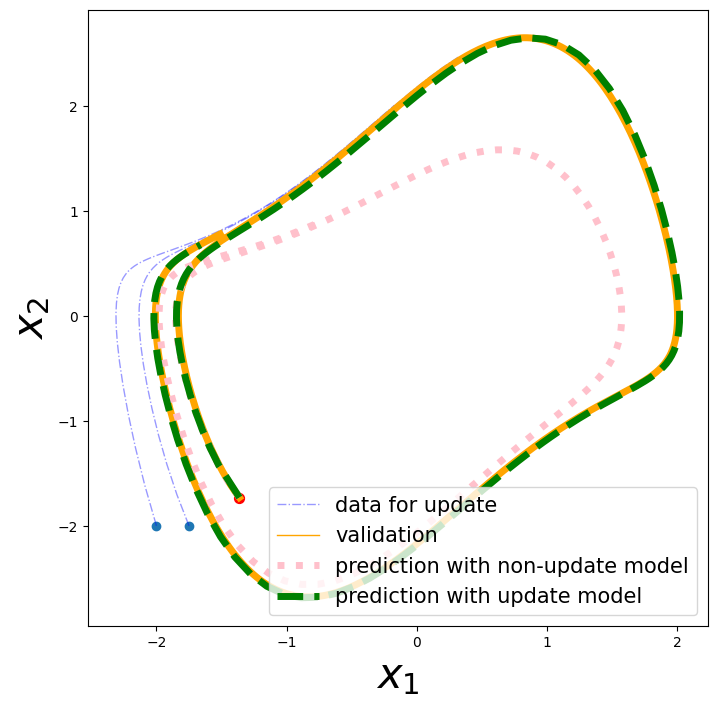

In [44]:
print(InitTestDataPoint_3)
LABEL=True
n = int((step+interval)/interval)-1
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(X2[0][:2], Y2[0][:2])
for i in range(2):
    if LABEL:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue", label="data for update", alpha=alpha, linewidth=lwidth, linestyle=lstyle)
        LABEL=False
    else:
        ax.plot(OnlineDataPoints[0, i*n+i:(i+1)*n+i], OnlineDataPoints[1, i*n+i:(i+1)*n+i], color="blue", alpha=alpha, linewidth=lwidth, linestyle=lstyle)
ax.scatter(InitTestDataPoint_3[0,0], InitTestDataPoint_3[0,1], color="red", s=50)
ax.plot(TestDataPoint_3[0, :1000], TestDataPoint_3[1,:1000], color="orange", label="validation", linewidth=5, linestyle="-")
ax.plot(preds_3rd[:200,0], preds_3rd[:200,1],label="prediction with non-update model", color="pink", linewidth=5, linestyle=":")
ax.plot(preds_window[122][:160,0], preds_window[122][:160,1], label="prediction with update model", color="green", linewidth=5, linestyle="--")
leg = ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0), fontsize=15)
leg.get_lines()[1].set_linewidth(1)
leg.get_lines()[0].set_linewidth(1)
ax.set_xlabel(r"$x_1$", size=30)
ax.set_ylabel(r"$x_2$", size=30)
# ax.set_xlim(-3, 5)
plt.show()

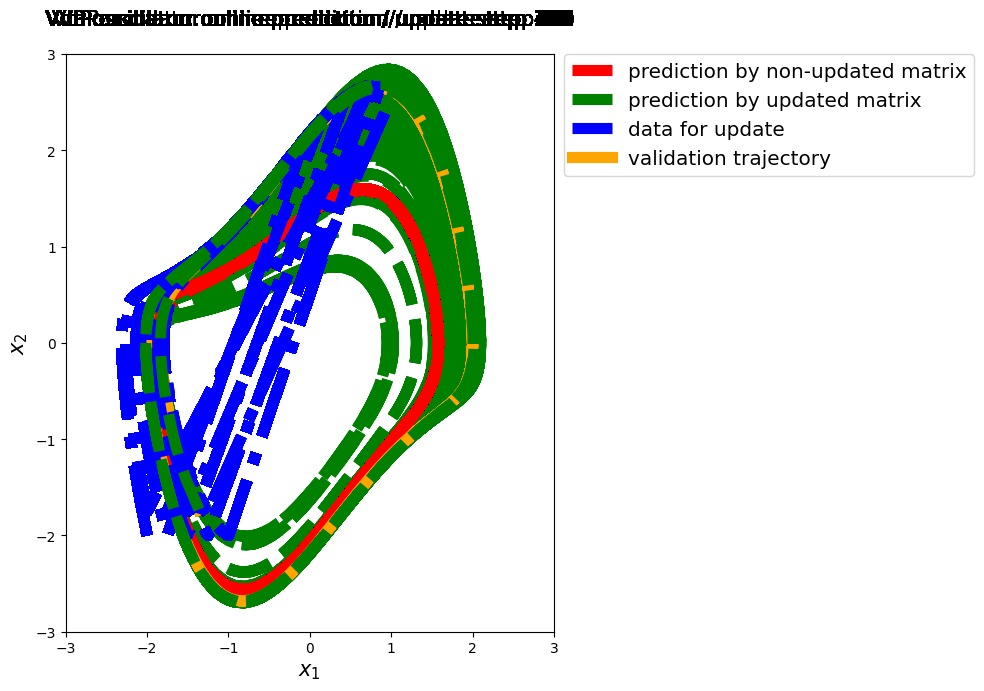

In [21]:
# （以下、preds_window, preds_3rd, TestDataPoint_3などは既に定義されているものとする）
# preds_window: shape = (101, 1002, 2)
# preds_3rd, TestDataPoint_3: shape = (1002, 2) or similar

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("$x_1$", size=15)
ax.set_ylabel("$x_2$", size=15)
# ax.set_title(...) は外して、フレーム毎にテキストで表示するようにする
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

artists = []  # すべてのフレームの情報を格納するリスト

end = 500  # フレーム数 = preds_windowの0次元目サイズ

for i in range(end):
    # 1フレーム分のアーティスト（Line2D など）を格納するリスト
    frame_artists = []

    # タイトルを表すテキストをフレームごとに作成
    # 位置 (0.5, 1.05) は Axes の相対座標。お好みで調整可
    title_text = ax.text(
        0.5, 1.05,
        f"VdP oscillator: online prediction / update step: {i}",
        transform=ax.transAxes,
        ha="center",   # 中央揃え
        size=15
    )
    frame_artists.append(title_text)

    # 最初のフレームだけ、非更新モデルや検証データの軌跡を描画
    if i == 0:
        line_nonupd, = ax.plot(
            preds_3rd[:, 0],
            preds_3rd[:, 1],
            '--r',
            linewidth=8,
            label="prediction by non-updated matrix"
        )
        frame_artists.append(line_nonupd)

        line_upd, = ax.plot(
            preds_window[i][:, 0],
            preds_window[i][:, 1],
            '--g',
            linewidth=8,
            label="prediction by updated matrix"
        )
        frame_artists.append(line_upd)

        line_train, = ax.plot(
            OnlineDataPoints[0, :i],
            OnlineDataPoints[1, :i],
            '-.b',
            linewidth=8,
            label="data for update"
        )
        frame_artists.append(line_train)

        line_true, = ax.plot(
            TestDataPoint_3[0, :],
            TestDataPoint_3[1, :],
            color="orange",
            linewidth=8,
            label="validation trajectory"
        )
        frame_artists.append(line_true)
        
    else:
        # 2フレーム目以降は updated matrix のみ追加
        line_nonupd, = ax.plot(
            preds_3rd[:, 0],
            preds_3rd[:, 1],
            '--r',
            linewidth=8
        )
        line_upd, = ax.plot(
            preds_window[i][:, 0],
            preds_window[i][:, 1],
            '--g',
            linewidth=8,
        )
        frame_artists.append(line_upd)
        line_true, = ax.plot(
            TestDataPoint_3[0, :],
            TestDataPoint_3[1, :],
            color="orange",
            linewidth=8,
        )
        frame_artists.append(line_true)

        line_train, = ax.plot(
            OnlineDataPoints[0, :i],
            OnlineDataPoints[1, :i],
            '-.b',
            linewidth=8,
        )
        frame_artists.append(line_train)
        
        line_upd, = ax.plot(
            preds_window[i][:, 0],
            preds_window[i][:, 1],
            '--g',
            linewidth=8,
        )
        frame_artists.append(line_upd)

    # フレーム分のアーティスト集合を artists に追加
    artists.append(frame_artists)

# 凡例を最後に固定
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0, fontsize="x-large")

# アニメーションを作成
anim = animation.ArtistAnimation(
    fig,
    artists,
    interval=200,      # フレーム間の表示時間[ms]
    blit=False,
    repeat=True
)
fig.tight_layout()
plt.show()

# GIFとして保存
anim.save("kedmd_prediction_vdp.gif", writer="pillow")

# KdV experiment

In [22]:
# scipy.sparse.csr_matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html


def make_differential_ops(nx, dx):

    # operators (matrix) that shift vector components (periodic boundary condition)
    f0 = np.identity(nx, dtype=int)  # f_{i}
    f1 = np.roll(f0, 1, axis=1)  # f_{i+1}
    f2 = np.roll(f0, 2, axis=1)  # f_{i+2}
    f_1 = f1.transpose()  # f_{i-1}
    f_2 = f2.transpose()  # f_{i-2}

    # (f_{i+1} - f_{i-1}) / (2 dx)
    deriv1 = sparse_matrix(f1 - f_1) / (2.0 * dx)

    # (f_{i+1} - 2f_{i} + f_{i-1}) / (dx^2)
    deriv2 = sparse_matrix(f1 - 2.0 * f0 + f_1) / dx**2

    # (f_{i+2} - 2f_{i+1} + 2f_{i-1} - f_{i-2}) / (2 dx^3)
    deriv3 = sparse_matrix(f2 - 2.0 * f1 + 2.0 * f_1 - f_2) / (2.0 * dx**3)

    return deriv1, deriv2, deriv3
coeff_nlin = 6.0
coeff_dis = 1.0
alpha = coeff_nlin/(6.0 * coeff_dis)

[e_1, e_2,e_3]= [-4.0,0.0,2.0]
elliptic_k = (e_3-e_2)/(e_3-e_1)

turning = 20020
def f_kdv(t, u, df1, df3, coeff_nlin, coeff_dis):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return coeff_nlin * u * u_x + coeff_dis* u_xxx

def main():
    # x mesh
    sys_length = (2*ellipk(elliptic_k))/np.sqrt(2*(e_3-e_1))
    nx = 50
    x_max = sys_length #100.0　# 本家から変えたところ
    x = np.linspace(-x_max, x_max, nx, endpoint=False)
    dx = x[1] - x[0]
    print("dx =", dx)
    t_max = 1.0

    nt = 50000
    t = np.linspace(0, t_max, nt+1)
    dt = t[1] - t[0]
    print("dt =", dt)
    
    # initial condition
    # 本家から変えた。
    # u0 = np.sin(x * (2.0 * np.pi / x_max))
    [_,cn,_,_] = ellipj(np.sqrt(alpha * (e_3-e_1)/2)*x, elliptic_k)
    print("周期:",ellipk(elliptic_k))
    u0 = e_2 + (e_3-e_2)* cn **2

    # differential operators
    op_df1, _, op_df3 = make_differential_ops(nx, dx)
    
    print("Solving equation...")
    period = 50
    u0 = u0.reshape(-1,1)
    nonlinear_term = [6.0]
    diffusion_term = [1.0]
    for i in range(nt):
        if i <= turning:
            coeff_nlin = 6.0 #* np.cos(2*np.pi*i/period)
            coeff_dis = 1.0
        else:
            coeff_nlin = 2.0
            coeff_dis = 0.8 #* np.sin(2*np.pi*i/period) 2.0
        nonlinear_term.append(coeff_nlin)
        diffusion_term.append(coeff_dis)
        sol = solve_ivp(f_kdv, t_span=t[i:i+2], y0=u0[:,-1], dense_output=True, args=(op_df1, op_df3, coeff_nlin, coeff_dis), rtol=1e-8)
        u0 = np.hstack([u0, sol.y[:, -1].reshape(-1,1)])
    print(sol.message)
    print("saving results...")
    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u0.T)
    print("done")
    return (x, t, u0.T, nonlinear_term, diffusion_term)

x, t, u_tx, coeff_nlin, coeff_dis= main()
delta_t = 20
u_tx = u_tx[::delta_t]
train_size = turning//delta_t - 1
update_size = turning//delta_t - 1
X_train = u_tx[:train_size, :]
Y_train = u_tx[1:train_size+1, :]
X_update = u_tx[train_size+1:train_size+update_size+1, :]
Y_update = u_tx[train_size+2:train_size+update_size+2, :]

print(X_train.shape)
print(Y_train.shape)
print(X_update.shape)
print(Y_update.shape)

dx = 0.04004309521824423
dt = 2e-05
周期: 1.733916885257935
Solving equation...
The solver successfully reached the end of the integration interval.
saving results...
done
(1000, 50)
(1000, 50)
(1000, 50)
(1000, 50)


In [23]:
pair_d2 = pdist(X_train.T, 'sqeuclidean')
sigma = np.sqrt(np.median(pair_d2) / np.log(X_train.shape[1]))
kedmd_kdv = kEDMD(X_train.T, Y_train.T, kernel="gaussian", eps=sigma)
kedmd_kdv_upd = kEDMD(X_update.T, Y_update.T, kernel="gaussian", eps=sigma)
s = time.time()
kedmd_kdv.fit(thr=1e-5)
kedmd_kdv_upd.fit(thr=1e-5)
e = time.time()
time_naive = e - s
print("kedmd done")

kedmd done


In [24]:
# validation data 生成用

def f_kdv(t, u, df1, df3, coeff_nlin, coeff_dis):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return coeff_nlin * u * u_x + coeff_dis* u_xxx

def main_val():
    # x mesh
    sys_length = (2*ellipk(elliptic_k))/np.sqrt(2*(e_3-e_1))
    nx = 50
    x_max = sys_length #100.0　# 本家から変えたところ
    x = np.linspace(-x_max, x_max, nx, endpoint=False)
    dx = x[1] - x[0]
    print("dx =", dx)
    t_max = 1.0

    nt = 50000
    t = np.linspace(0, t_max, nt+1)
    dt = t[1] - t[0]
    print("dt =", dt)
    
    # initial condition
    # 本家から変えた。
    # u0 = np.sin(x * (2.0 * np.pi / x_max))
    [_,cn,_,_] = ellipj(np.sqrt(alpha * (e_3-e_1)/2)*x, elliptic_k)
    print("周期:",ellipk(elliptic_k))
    u0 = e_2 + (e_3-e_2)* cn **2

    # differential operators
    op_df1, _, op_df3 = make_differential_ops(nx, dx)
    
    print("Solving equation...")
    period = 50
    u0 = u0.reshape(-1,1)
    coeff_nlin = 2.0 #6.0
    coeff_dis = 0.8 #1.0
    for i in range(nt):
        sol = solve_ivp(f_kdv, t_span=t[i:i+2], y0=u0[:,-1], dense_output=True, args=(op_df1, op_df3, coeff_nlin, coeff_dis), rtol=1e-8)
        u0 = np.hstack([u0, sol.y[:, -1].reshape(-1,1)])
    print(sol.message)
    print("saving results...")
    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u0.T)
    print("done")
    return (x, t, u0.T, coeff_nlin, coeff_dis)
validation_size = 300
_, _, u_tx_val, coeff_nlin_val, coeff_dis_val  = main_val()
print(u_tx_val.shape)
u_tx_val = u_tx_val[::delta_t]
validation_init = u_tx_val[0, :]
validation_data = u_tx_val[:validation_size, :]

dx = 0.04004309521824423
dt = 2e-05
周期: 1.733916885257935
Solving equation...
The solver successfully reached the end of the integration interval.
saving results...
done
(50001, 50)


npz.files = ['x', 't', 'u_tx']
x.shape = (50,)
t.shape = (50001,)
u_tx.shape = (50001, 50)
Making animation...


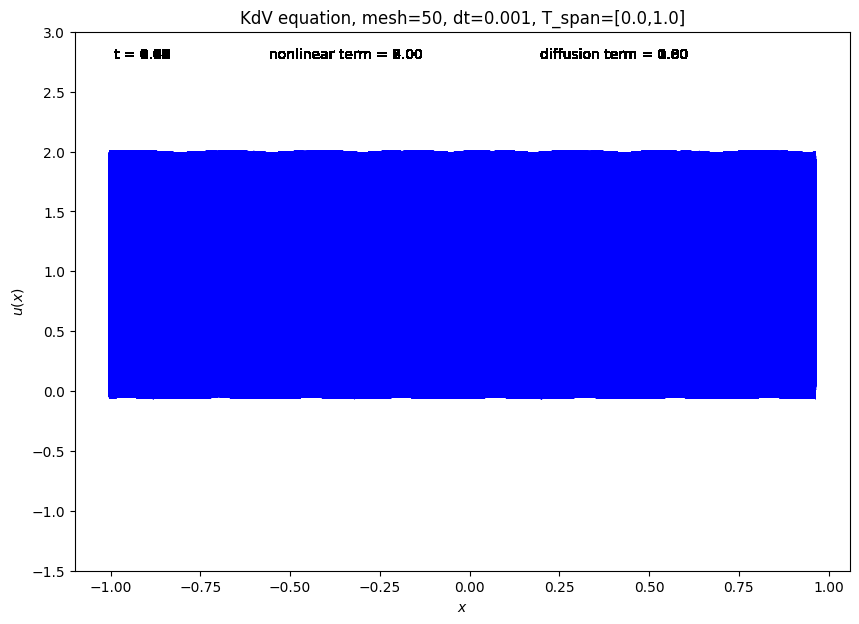

In [ ]:
def save_animation(x, t, u_tx, ymin, ymax, filename):
    fig, ax = plt.subplots(figsize=(10, 7))

    # common setting for plot
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    ax.set_ylim((ymin, ymax))
    ax.set_title("KdV equation, mesh={}, dt={}, T_span=[{},{}]".format(50, 0.001, 0.0, 1.0))
    artists = []  # list of plot
    for i in range(t.size):
        # Make i-th plot
        # ax.set_title("t = %f" % t[i])
        artist = ax.plot(x, u_tx[i, :], '-b')
        artist += [ax.text(0.05, 0.95, "t = %.2f" % t[i], transform=ax.transAxes)]
        artist += [ax.text(0.25, 0.95, "nonlinear term = %.2f" % coeff_nlin[i], transform=ax.transAxes)]
        artist += [ax.text(0.60, 0.95, "diffusion term = %.2f" % coeff_dis[i], transform=ax.transAxes)]
        artists.append(artist)

    # Make animation
    anim = animation.ArtistAnimation(fig, artists, interval=0.01, repeat=False)
    plt.show()

    # Save animation
    anim.save(filename, writer="pillow")  # writer="pillow" or "imagemagick" for GIF
    print("saved as '{}'".format(filename))
def load_and_make_anime():
    # Load results
    npz = np.load("kdv_solve_ivp.npz")
    print("npz.files =", npz.files)

    x = npz['x']
    t = npz['t']
    u_tx = npz['u_tx']
    print("x.shape =", x.shape)
    print("t.shape =", t.shape)
    print("u_tx.shape =", u_tx.shape)

    # make an animation
    print("Making animation...")
    save_animation(x, t, u_tx, ymin=-1.5, ymax=3.0, filename="kdv_solve_ivp.gif")
load_and_make_anime()
print("done")

In [ ]:
# dim * data
# Batch
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

In [ ]:
pred = validation_init
pred_upd = validation_init
preds = []
preds_upd = []
for j in range(validation_size):
    pred = kedmd_kdv.predict(pred)
    pred_upd = kedmd_kdv_upd.predict(pred_upd)
    preds.append(pred)
    preds_upd.append(pred_upd)
preds_base = np.array(preds)
preds_base_upd = np.array(preds_upd)
dt = t[1] - t[0]
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
Error_base = validation_data - preds_base
Error_base_upd = validation_data - preds_base_upd
rmse = np.sqrt((Error_base**2).sum(axis=1) / validation_size)
rmse_upd = np.sqrt((Error_base_upd**2).sum(axis=1) / validation_size)
ax1.plot(np.arange(0, validation_size)*dt, rmse, label="non updated model")
ax1.plot(np.arange(0, validation_size)*dt, rmse_upd, label="update data model")
ax1.set_xlabel("time")
ax1.set_ylabel("RMSE")
ax1.legend()
plt.show()

In [ ]:
# update kedmd
s_expected = copy.copy(kedmd_kdv_upd.s)
_X = X_train.copy()
_Y = Y_train.copy()
time_proposal = []
preds_proposal = [[] for i in range(update_size-1)]
rmse_proposal = []
preds_all = []
preds_all_1 = []
ts = []
for i in range(update_size):
    print(kedmd_kdv.s.shape)
    print(kedmd_kdv.s)
    print("expect:", s_expected)
    s = time.time()
    kedmd_kdv_upd.window_update(new_x=X_update[i, :], new_y=Y_update[i, :], idx=i, thr=1e-3)
    e = time.time()
    ts.append(e-s)
    pred = validation_init
    pred_1 = validation_init
    preds = []
    preds_1 = []
    for j in range(validation_size):
        pred = kedmd_kdv_upd.predict(pred)
        preds.append(pred)
    preds = np.array(preds)
    preds_all.append(preds)
    print(i+1)

In [ ]:
dt = t[1] - t[0]
fig = plt.figure(figsize=(12, 8))
t_plot = np.arange(0, validation_size)*dt
ax1 = fig.add_subplot(221)
e_base = validation_data - preds_base
e_250 = validation_data - preds_all[249]
e_500 = validation_data - preds_all[499]
rmse = np.sqrt((e_base**2).sum(axis=1)/validation_size)
rmse_250 = np.sqrt((e_250**2).sum(axis=1)/validation_size)
rmse_500 = np.sqrt((e_500**2).sum(axis=1) / validation_size)
ax1.plot(t_plot[::10], rmse[::10], "-o",label="no(0) update model", lw=2., ms=4.5)
ax1.plot(t_plot[::10], rmse_250[::10], "-^", label="250 updates model", lw=2., ms=4.5)
ax1.plot(t_plot[::10], rmse_500[::10], "-s", label="500 updates model", lw=2., ms=4.5)
ax1.set_xlabel("time", size=20)
ax1.set_ylabel("RMSE", size=20)
ax1.legend(loc="lower right", bbox_to_anchor=(1.67, 0.01,), borderaxespad=0, fontsize=15)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax1 = ax
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u(x)$")
ax1.set_ylim((-1.5, 3.0))
ax1.set_title("KdV equation, mesh={}, dt={}, T_span=[{},{}]".format(50, 0.001, 0.0, 1.0))

artists = []  # list of plot
print(validation_data.shape)
n_1 = 249
n_2 = 499
n_3 = 749
n_4 = 999
preds_update_1 = preds_all[n_1]
preds_update_2 = preds_all[n_2]
preds_update_3 = preds_all[n_3]
preds_update_4 = preds_all[n_4]
for i in range(validation_size):
    if i == 0:
        artist1 = ax1.plot(x, preds_base[i, :], '--g', label="prediction by non-updated model")
        artist1 += ax1.plot(x, preds_update_1[i, :], '--r', label="prediction by 250 updated model")
        artist1 += ax1.plot(x, preds_update_2[i, :], '--c', label="prediction by 500 updated model")
        artist1 += ax1.plot(x, preds_update_3[i, :], '--k', label="prediction by 750 updated model")
        artist1 += ax1.plot(x, preds_update_4[i, :], '--m', label="prediction by 1000(all data swapped) updated model")
        artist1 += ax1.plot(x, validation_data[i, :], '--b', label="target(validation data)", alpha=0.3)
        #artist1 += ax1.plot(x, u_tx[:train_size, :][i, :], '-k', label="true value(train)", alpha=0.3)
    else:
        artist1 = ax1.plot(x, preds_base[i, :], '--g')
        artist1 += ax1.plot(x, preds_update_1[i, :], '--r')
        artist1 += ax1.plot(x, preds_update_2[i, :], '--c')
        artist1 += ax1.plot(x, preds_update_3[i, :], '--k')
        artist1 += ax1.plot(x, preds_update_4[i, :], '--m')
        artist1 += ax1.plot(x, validation_data[i, :], '--b', alpha=0.3)
        #artist1 += ax1.plot(x, u_tx[:train_size, :][i, :], '-k', alpha=0.3)
    artist1 += [ax.text(0.05, 0.95, "t = %.5f" % t[i], transform=ax.transAxes)]
    artist1 += [ax.text(0.25, 0.95, "nonlinear term = %.2f" % coeff_nlin_val, transform=ax.transAxes)]
    artist1 += [ax.text(0.60, 0.95, "diffusion term = %.2f" % coeff_dis_val, transform=ax.transAxes)]
    artists.append(artist1)
ax1.legend(loc="lower right", bbox_to_anchor=(0.99, 0.01,), borderaxespad=0)
# Make animation
anim = animation.ArtistAnimation(fig, artists, interval=11, repeat=False)
plt.show()
# Save animation
anim.save("kedmd_prediction.gif", writer="pillow")  # writer="pillow" or "imagemagick" for GIF

In [ ]:
plt.plot(x, preds_base[-1, :], '-o', label="prediction by no(0) update model")
plt.plot(x, preds_update_1[-1, :], '-^', label="prediction by 250 updates model")
plt.plot(x, preds_update_2[-1, :], '-s', label="prediction by 500 updates model")
plt.plot(x, validation_data[-1, :], '-k', label="target(validation data)", alpha=0.3)
plt.legend(loc="lower right", bbox_to_anchor=(1.86, 0.01,), borderaxespad=0, fontsize=15)
plt.xlabel("x", size=20)
plt.ylabel("u(x)", size=20)
plt.show()

In [ ]:
# randamized matrix
import time
rng = np.random.default_rng(10)
X_rnd = rng.normal(0, 1, (1000, 256))
Y_rnd = rng.normal(0, 1, (1000, 256))
new_data = rng.normal(0, 1, (1001, 256))
new_X_rnd = new_data[:-1, :]
new_Y_rnd = new_data[1:, :]
kedmd_update = kEDMD(X=X_rnd.T, Y=Y_rnd.T, kernel="polynomial", p=3, c=1)
kedmd_update_rank10 = kEDMD(X=X_rnd.T, Y=Y_rnd.T, kernel="polynomial", p=3, c=1)
kedmd_update_rank100 = kEDMD(X=X_rnd.T, Y=Y_rnd.T, kernel="polynomial", p=3, c=1)
kedmd_update.fit()
kedmd_update_rank10.fit(thr=10)
kedmd_update_rank100.fit(thr=100)
exe_time_base = []
exe_time_update = []
exe_time_update_rank10 = []
exe_time_update_rank100 = []
for i, new_data in enumerate(zip(new_X_rnd, new_Y_rnd)):
    new_x, new_y = new_data
    # 素朴な方法による更新
    kedmd_base = kEDMD(X=np.vstack((X_rnd[1:], new_x.reshape(1,-1))).T, Y=np.vstack((Y_rnd[1:], new_y.reshape(1,-1))).T, kernel="polynomial", p=3, c=1)
    start = time.time()

    kedmd_base.fit()
    end = time.time()
    exe_time_base += [end - start]
        
    # アルゴリズムによるfull_rankでの更新
    start = time.time()
    kedmd_update.window_update(new_x=new_x, new_y=new_y, idx=i, thr=0)
    end = time.time()
    exe_time_update += [end - start]
    
    # rank数を落としたもの
    start = time.time()
    kedmd_update_rank10.window_update(new_x=new_x, new_y=new_y, idx=i, thr=10)
    end = time.time()
    exe_time_update_rank10 += [end - start]

    # rank数を落としたもの
    start = time.time()
    kedmd_update_rank100.window_update(new_x=new_x, new_y=new_y, idx=i, thr=100)
    end = time.time()
    exe_time_update_rank100 += [end - start]

    print("iteration", i+1)
    if i % 100 == 99 or i == 0:
        if i+1 == 100:
            break

In [ ]:
for i in [exe_time_base,exe_time_update,exe_time_update_rank100,exe_time_update_rank10]:
    print(np.array(i).mean())
plt.boxplot([exe_time_base,exe_time_update,exe_time_update_rank100,exe_time_update_rank10], 
            tick_labels=["naive", "r=1000(full_rank)", "r=100","r=10"],
            sym="")
plt.ylabel("computational time(s)")
plt.title("Computational time with rank–truncated updates")
plt.savefig("computational comparison via rank.svg")
plt.show()